In [2]:
import importlib
import Utils.dataset_preparation as pfl
importlib.reload(pfl)
print(dir(pfl))


['DataFrame', 'OneHotEncoder', 'SMOTE', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'model_input_preparation', 'np', 'os', 'pd', 'train_test_split']


# import lib and function

In [7]:
import pandas as pd
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from Utils.path_file_loader import target_path
from Utils.Evaluation_metrix import evaluate_sklearn_model
from Utils.dataset_preparation import model_input_preparation
from sklearn.metrics import classification_report
import optuna
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn 
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt, pi, exp
from sklearn.model_selection import train_test_split


sns.set(style="white")


# Data Preprocessing

In [4]:
df = pd.read_csv(target_path("DataBase\Cleaned_data.csv"), encoding="utf-8")
df = df.drop(columns=['customerID'])
df = df.rename(columns={'Churn': 'label'})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Declare variable

In [5]:
categorical_feature_list = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

numerical_feature_list = [
    'SeniorCitizen', 
    'tenure', 
    'MonthlyCharges',
    'TotalCharges', 
]

one_hot_feature = ['tenure',
 'Contract_Two year',
 'TotalCharges',
 'Contract_Month-to-month',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'PaperlessBilling_No',
 'MultipleLines_No',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'DeviceProtection_No internet service',
 'StreamingTV_No internet service',
 'OnlineBackup_No internet service',
 'TechSupport_No internet service',
 'StreamingMovies_No internet service',
 'PhoneService_Yes',
 'Dependents_Yes',
 'StreamingMovies_No',
 'OnlineSecurity_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'TechSupport_Yes',
 'StreamingMovies_Yes',
 'Partner_No',
 'OnlineSecurity_No',
 'gender_Male',
 'StreamingTV_No',
 'PaymentMethod_Mailed check',
 'TechSupport_No',
 'PaymentMethod_Bank transfer (automatic)',
 'StreamingTV_Yes',
 'gender_Female',
 'Partner_Yes',
 'OnlineBackup_Yes', 
 'Dependents_No',
 'SeniorCitizen', 
 'PhoneService_No', 
 'MultipleLines_No phone service',
 'Contract_One year'
]

normal_selected_feature = [
    'Contract', 
    'tenure', 
    'MonthlyCharges', 
    'OnlineSecurity', 
    'TechSupport', 
    'InternetService', 
    'PaymentMethod', 
    'PaperlessBilling', 
    'TotalCharges', 
    'StreamingMovies', 
    'MultipleLines', 
    'OnlineBackup', 
    'SeniorCitizen'
]

# Regression model

## Data Preprocessing

In [8]:
df_numerical = df[numerical_feature_list]
df_numerical.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


## Linear Regression

### lib

In [17]:
X = df_numerical[['tenure']]
y = df_numerical['TotalCharges']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", model.score(X_test, y_test))


R² Score: 0.6700723339739993


### from scratch

In [20]:
import numpy as np

class UpdatedLinearRegressionScratch:
    """
    Custom implementation of linear regression using gradient descent.
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.coef_ = None
        self.intercept_ = None
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        """
        Fits the linear regression model to the given data using gradient descent.
        Args:
            X: A numpy array of shape (n_samples, n_features) representing the input data.
            y: A numpy array of shape (n_samples,) representing the target values.
        """
        # Ensure X is numpy 2D
        if isinstance(X, np.ndarray) == False:
            X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.array(y)

        n_samples, n_features = X.shape

        # Initialize parameters
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        # Gradient descent loop
        for _ in range(self.n_iterations):
            # Predictions
            y_pred = np.dot(X, self.coef_) + self.intercept_

            # Errors
            residuals = y_pred - y

            # Gradients
            d_coef = (2/n_samples) * np.dot(X.T, residuals)
            d_intercept = (2/n_samples) * np.sum(residuals)

            # Update
            self.coef_ -= self.learning_rate * d_coef
            self.intercept_ -= self.learning_rate * d_intercept

    def predict(self, X):
        if isinstance(X, np.ndarray) == False:
            X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return np.dot(X, self.coef_) + self.intercept_

    def score(self, X, y):
        """
        Compute R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - ss_res/ss_tot


In [23]:
# Convert to numpy (important for scratch implementation)
X_train_np = X_train.values.reshape(-1, 1)
X_test_np = X_test.values.reshape(-1, 1)
y_train_np = y_train.values
y_test_np = y_test.values

# Train
lr = 0.0001
n_iter = 100
lin_reg_updated = UpdatedLinearRegressionScratch(learning_rate=lr, n_iterations=n_iter)
lin_reg_updated.fit(X_train_np, y_train_np)

# Results
print(f"Intercept : {lin_reg_updated.intercept_}")
print(f"Coef : {lin_reg_updated.coef_[0]}")

# Evaluate R²
print("R² Score:", lin_reg_updated.score(X_test_np, y_test_np))


Intercept : 0.0012240712518423544
Coef : 72.85249178160025
R² Score: 0.668414822088552


## multiple regression

### lib

In [24]:
X = df_numerical[['tenure', 'MonthlyCharges']]
y = df_numerical['TotalCharges']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", model.score(X_test, y_test))


R² Score: 0.8902238820918934


### from scratch

In [25]:
import numpy as np

class MultipleLinearRegressionScratch:
    """
    Custom implementation of multiple linear regression using gradient descent.
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.coef_ = None
        self.intercept_ = None
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        """
        Fits the model to the given data using gradient descent.
        X: numpy array (n_samples, n_features)
        y: numpy array (n_samples,)
        """
        # Ensure numpy arrays
        X = np.array(X)
        y = np.array(y)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        n_samples, n_features = X.shape

        # Initialize parameters
        self.coef_ = np.zeros((n_features, 1))
        self.intercept_ = 0

        # Gradient descent
        for _ in range(self.n_iterations):
            # Predictions
            y_pred = np.dot(X, self.coef_) + self.intercept_

            # Errors
            residuals = y_pred - y

            # Gradients
            d_coef = (2/n_samples) * np.dot(X.T, residuals)
            d_intercept = (2/n_samples) * np.sum(residuals)

            # Update
            self.coef_ -= self.learning_rate * d_coef
            self.intercept_ -= self.learning_rate * d_intercept

        # Flatten coefficients for readability
        self.coef_ = self.coef_.flatten()

    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.coef_) + self.intercept_

    def score(self, X, y):
        """Compute R² score"""
        y = np.array(y)
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - ss_res/ss_tot


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select multiple features
X = df_numerical[['tenure', 'MonthlyCharges']]
y = df_numerical['TotalCharges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data (important for gradient descent stability)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

# Train model
lr = 0.001
n_iter = 2000
mlr = MultipleLinearRegressionScratch(learning_rate=lr, n_iterations=n_iter)
mlr.fit(X_train_scaled, y_train_scaled)

# Results
print("Intercept:", mlr.intercept_)
print("Coefficients:", mlr.coef_)
print("R² Score (scaled):", mlr.score(X_test_scaled, y_test_scaled))

# Back to original scale predictions
y_pred_scaled = mlr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()


Intercept: 2.79483295655344e-16
Coefficients: [0.69793274 0.47614057]
R² Score (scaled): 0.8903244991041388


## Polynomial Regression

### from lib

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = df_numerical[['tenure', 'MonthlyCharges']]
y = df_numerical['TotalCharges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

print("Polynomial Feature Names:", poly.get_feature_names_out(['tenure','MonthlyCharges']))
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Polynomial Feature Names: ['tenure' 'MonthlyCharges' 'tenure^2' 'tenure MonthlyCharges'
 'MonthlyCharges^2']
R² Score: 0.9991078011147159
MSE: 4641.585647033761


### from scratch

In [29]:
import numpy as np

class PolynomialRegressionScratch:
    """
    Polynomial Regression using gradient descent (from scratch).
    """
    def __init__(self, degree=2, learning_rate=0.01, n_iterations=1000):
        self.degree = degree
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.coef_ = None
        self.intercept_ = None

    def _expand_features(self, X):
        """
        Expand features into polynomial features (degree, interactions).
        X: (n_samples, n_features)
        """
        n_samples, n_features = X.shape
        features = [np.ones((n_samples, 1))]  # bias column
        
        # Generate polynomial terms up to degree
        for d in range(1, self.degree + 1):
            for combo in np.ndindex(*(n_features,) * d):
                if sorted(combo) == list(combo):  # avoid duplicates, enforce order
                    term = np.prod(X[:, combo], axis=1).reshape(-1, 1)
                    features.append(term)
        return np.hstack(features)   # shape (n_samples, n_poly_features)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        # Expand to polynomial features
        X_poly = self._expand_features(X)

        n_samples, n_features = X_poly.shape

        # Initialize coefficients
        self.theta = np.zeros((n_features, 1))

        # Gradient descent
        for _ in range(self.n_iterations):
            y_pred = X_poly @ self.theta
            residuals = y_pred - y

            grad = (2/n_samples) * (X_poly.T @ residuals)
            self.theta -= self.learning_rate * grad

        # Store results in sklearn-like format
        self.intercept_ = self.theta[0][0]
        self.coef_ = self.theta[1:].flatten()

    def predict(self, X):
        X = np.array(X)
        X_poly = self._expand_features(X)
        return (X_poly @ self.theta).flatten()

    def score(self, X, y):
        y = np.array(y)
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - ss_res/ss_tot


In [34]:

X = df_numerical[['tenure', 'MonthlyCharges']].values
y = df_numerical['TotalCharges'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly_reg = PolynomialRegressionScratch(degree=2, learning_rate=0.000000001, n_iterations=500)
poly_reg.fit(X_train, y_train)

print("Intercept:", poly_reg.intercept_)
print("Coefs:", poly_reg.coef_)
print("R² Score:", poly_reg.score(X_test, y_test))

y_pred = poly_reg.predict(X_test)


Intercept: -6.750855534144396e-05
Coefs: [ 0.00446269 -0.0013676   0.33113082  0.61702211  0.08356311]
R² Score: 0.9779988792654429


# Model

## Deep Learning

### MLP (Only from scratch)

#### prepare dataset

In [4]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long) 

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



#### Training function

In [36]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler=None, num_epochs=50, device="cpu"):
    model.to(device)
    best_model_wts = None
    best_acc = -float("inf")
    history = {"train_loss": [], "val_loss": [], "accuracy": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if scheduler:
            scheduler.step()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(targets.cpu().numpy().flatten())

        avg_val_loss = val_loss / len(test_loader)
        acc = accuracy_score(all_targets, all_preds)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["accuracy"].append(acc)

        if acc > best_acc:
            best_acc = acc
            best_model_wts = model.state_dict()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f}")

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, history


#### Evaluation Metrix

In [ ]:
def evaluate_model(model, test_loader, criterion, device="cpu"):
    model.to(device)
    model.eval()

    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy().flatten())

    avg_loss = total_loss / len(test_loader)

    # Metrics
    cm = confusion_matrix(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)  # Sensitivity
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])   # TNR
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    r2 = r2_score(all_targets, all_preds)

    print("\nEvaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity (TNR): {specificity:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"R² score: {r2:.4f}")

    # --- PLOTS ---
    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.title("ROC Curve")
    plt.show()

    return {
        "loss": avg_loss,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "r2": r2,
        "confusion_matrix": cm
    }


Epoch 10/10 | Train Loss: 0.3993 | Val Loss: 0.4126 | Acc: 0.8084

Evaluation Results:
Loss: 0.4126
Accuracy: 0.8084
Precision: 0.6667
Sensitivity (Recall): 0.5523
Specificity (TNR): 0.9006
F1-score: 0.6041
ROC AUC: 0.8499
R² score: 0.0155


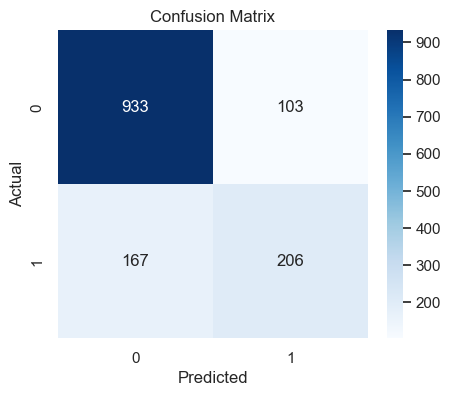

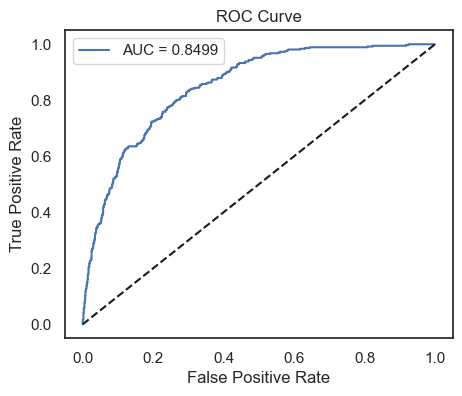

In [39]:

class ANN(nn.Module): 
    def __init__(self): 
        super(ANN, self).__init__() 
        self.fc1 = nn.Linear(in_features=45, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64) 
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=2)
    def forward(self, x): 
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x)) 
        x = self.fc4(x) 
        return x
model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
trained_model, history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Evaluate
results = evaluate_model(trained_model, test_loader, criterion)


## Vector Base

### Logistic Regression

In [9]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

##### Optuna auto-tuning hyper parameter Function

In [40]:
def Logistic_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    C = trial.suggest_categorical("C", [0.1, 1, 10])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"])


    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if penalty == "l2" and solver not in ["liblinear", "saga", "lbfgs"]:
        raise optuna.exceptions.TrialPruned()

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=100,
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


##### Lib model

In [43]:
model = LogisticRegression(
    random_state=42,
    C = 1,
    penalty='l1',
    solver='saga'
).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8232789212207239


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Evaluation Results:
Accuracy: 0.8233
Precision: 0.6902
Sensitivity (Recall): 0.6032
Specificity (TNR): 0.9025
F1-score: 0.6438
ROC AUC: 0.8624
R² score: 0.0921
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



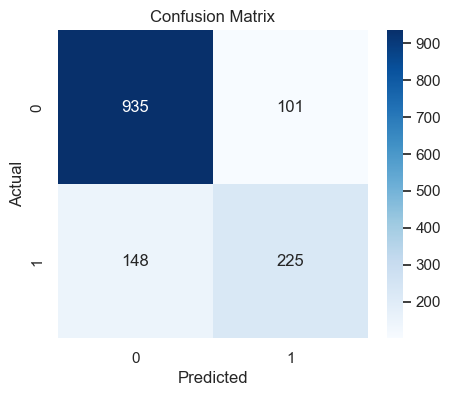

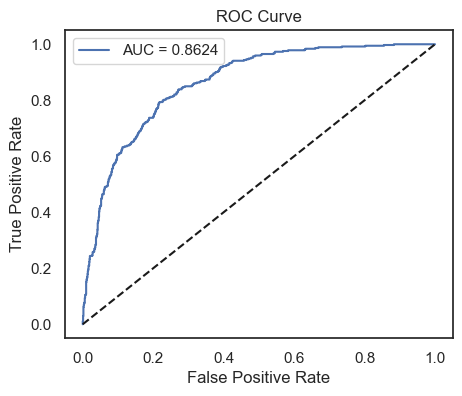

{'accuracy': 0.8232789212207239,
 'precision': 0.6901840490797546,
 'recall': 0.6032171581769437,
 'specificity': np.float64(0.9025096525096525),
 'f1': 0.6437768240343348,
 'auc': 0.8624310350181664,
 'r2': 0.09209218793669216,
 'confusion_matrix': array([[935, 101],
        [148, 225]])}

In [51]:
evaluate_sklearn_model(model, X_test, y_test)

##### From scratch model

In [5]:
class LogisticRegressionScratchBothMSEandBCE:
    def __init__(self, learning_rate=0.001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.b = None
        self.losses_MSE = []
        self.losses_BCE = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        probs = self.sigmoid(z)

        # Return the class with the highest probability
        return np.where(probs >= 0.5, 1, 0)

    def initialize_weights(self, n_features):
        self.w = np.zeros((n_features, 1))  # Init with the same column number as feature
        self.b = 0

    def cost_function_MSE(self, h, y):
        m = len(y)
        # reg_term = (0.01 / (2 * m)) * np.sum(self.w ** 2)
        cost = (1/m) * np.sum((h - y)**2)

        return cost #+ reg_term

    def cost_function_BCE(self, h, y):
        m = len(y)
        # reg_term = (0.01 / (2 * m)) * np.sum(self.w ** 2)
        cost = -(1 / m) * np.sum(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))

        return cost #+ reg_term

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)  # Ensure y is a column vector
        print(X.shape, y.shape)
        m = len(y)
        n_features = X.shape[1]
        self.initialize_weights(n_features)

        for i in range(self.num_iterations):
            # Forward prop
            probs = self.predict(X)

            # Cost
            # error = -(1 / m) * np.sum(y * np.log(probs + 1e-8) + (1 - y) * np.log(1 - probs + 1e-8))
            MSE_error = self.cost_function_MSE(probs, y)
            self.losses_MSE.append(MSE_error)

            BCE_error = self.cost_function_BCE(probs, y)
            self.losses_BCE.append(BCE_error)

            # Calculate the gradient of the error with respect to the weights
            gradient_w = (1 / m) * np.dot(X.T, (probs - y))
            gradient_b = (1 / m) * np.sum(probs - y)

            # Update the weights using the gradient and the learning rate
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b

            # cost compute if more iteration (optional)
            if i % 100 == 0:
                print(f"Iteration {i}, MSE_Cost: {MSE_error}, BCE_Cost: {BCE_error}")

    def plot_loss(self):

        # plt.subtitle("Comparing MSE and BCE chart")
        plt.figure(figsize=(16, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(self.num_iterations), self.losses_MSE, label='MSE Loss')
        plt.xlabel("Iteration")
        plt.ylabel("Loss (MSE)")
        plt.title("Loss Curve: Logistic Regression (MSE)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        plt.subplot(1, 2, 2)
        plt.plot(range(self.num_iterations), self.losses_BCE, label='BCE Loss')
        plt.xlabel("Iteration")
        plt.ylabel("Loss (BCE)")
        plt.title("Loss Curve: Logistic Regression (BCE)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        plt.show()


(5634, 45) (5634, 1)
Iteration 0, MSE_Cost: 0.7344692935747249, BCE_Cost: 13.529424370520928
Iteration 100, MSE_Cost: 0.25452609158679446, BCE_Cost: 4.688543866671582
Iteration 200, MSE_Cost: 0.24849130280440185, BCE_Cost: 4.577378949093595
Iteration 300, MSE_Cost: 0.25576854810081645, BCE_Cost: 4.71143076146705
Iteration 400, MSE_Cost: 0.24139155129570464, BCE_Cost: 4.446596693119493
Iteration 500, MSE_Cost: 0.2445864394746184, BCE_Cost: 4.5054487083078385
Iteration 600, MSE_Cost: 0.2552360667376642, BCE_Cost: 4.701622092268993
Iteration 700, MSE_Cost: 0.24724884629037983, BCE_Cost: 4.554492054298127
Iteration 800, MSE_Cost: 0.25576854810081645, BCE_Cost: 4.71143076146705
Iteration 900, MSE_Cost: 0.2334043308484203, BCE_Cost: 4.299466655148627


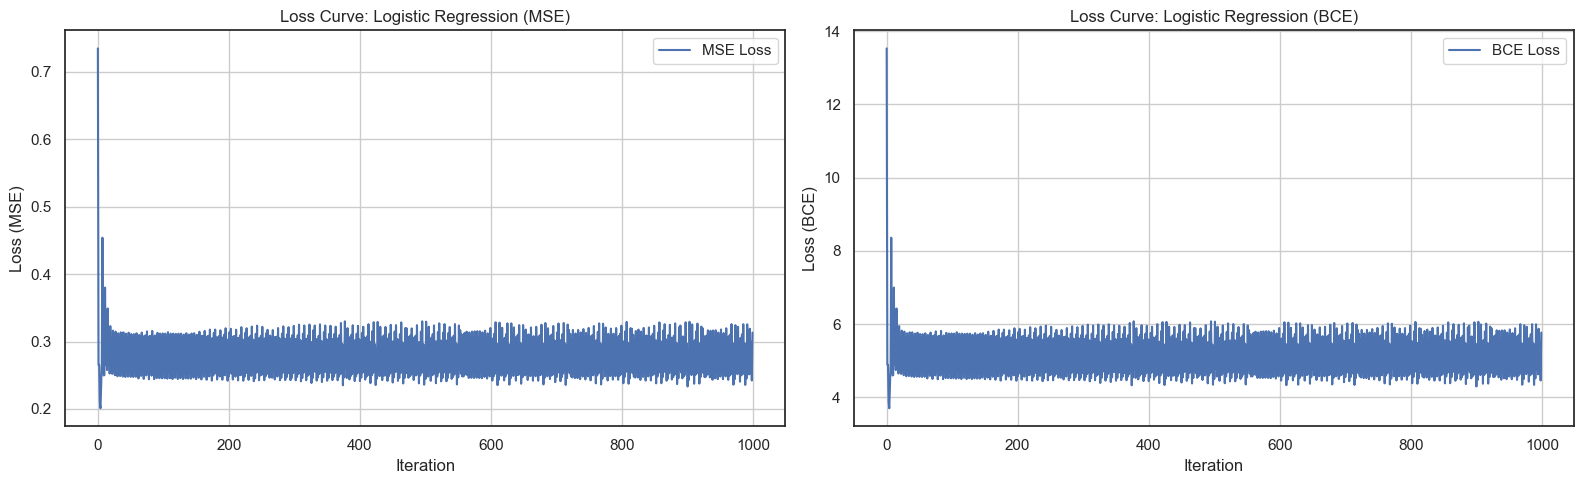

In [ ]:

model = LogisticRegressionScratchBothMSEandBCE(learning_rate=1e-4, num_iterations=1000)
model.fit(X_train, y_train)


Evaluation Results:
Accuracy: 0.7495
Precision: 0.8333
Sensitivity (Recall): 0.0670
Specificity (TNR): 0.9952
F1-score: 0.1241
ROC AUC: 0.5311
R² score: -0.2871
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1036
           1       0.83      0.07      0.12       373

    accuracy                           0.75      1409
   macro avg       0.79      0.53      0.49      1409
weighted avg       0.77      0.75      0.66      1409



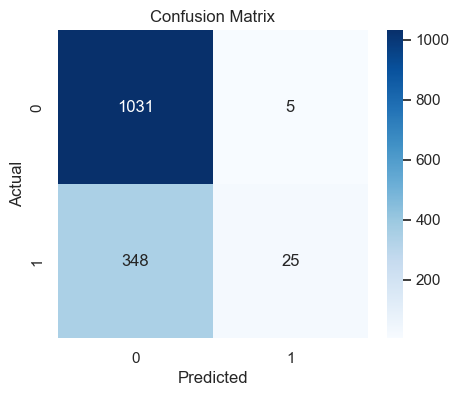

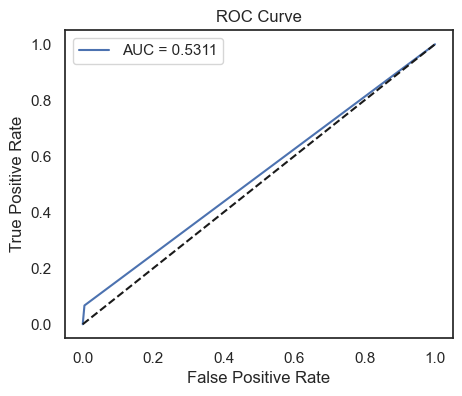

{'accuracy': 0.7494677075940384,
 'precision': 0.8333333333333334,
 'recall': 0.06702412868632708,
 'specificity': np.float64(0.9951737451737451),
 'f1': 0.12406947890818859,
 'auc': 0.5310989369300361,
 'r2': -0.28711428778452897,
 'confusion_matrix': array([[1031,    5],
        [ 348,   25]])}

In [12]:
evaluate_sklearn_model(model, X_test, y_test)

### Naive Bayes

In [14]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = True
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.38905447 -0.38905447 -0.38905447 ... -0.38905447 -0.38905447
 -0.38905447]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.26792424  1.11636705 -1.10688866 ... -0.43571712 -1.02299222
 -0.72935467]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

##### Lib Naive bayes

In [ ]:
model = GaussianNB().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.7550749154180764, test set 0.7061745919091554


##### From scratch NB

In [23]:
import numpy as np
import pandas as pd
from math import sqrt, pi, exp

class NaiveBayesClassifier:
    def __init__(self, categorical_features=None, numerical_features=None, use_add1_smoothing=True):
        self.categorical_features = categorical_features or []
        self.numerical_features = numerical_features or []
        self.use_add1_smoothing = use_add1_smoothing

    def fit(self, X, y):
        """ Fit Naive Bayes model """
        X, y = pd.DataFrame(X), pd.Series(y)

        self.classes_, counts = np.unique(y, return_counts=True)
        self.class_priors_ = counts / counts.sum()

        # --- Likelihoods for categorical ---
        self.likelihoods_categorical_ = {}
        self.feature_values_ = {}
        for feature in self.categorical_features:
            self.feature_values_[feature] = X[feature].unique()
            self.likelihoods_categorical_[feature] = {}
            for cls in self.classes_:
                mask = (y == cls)
                total = mask.sum()
                value_counts = X.loc[mask, feature].value_counts().to_dict()

                probs = {}
                for val in self.feature_values_[feature]:
                    count = value_counts.get(val, 0)
                    if self.use_add1_smoothing:
                        probs[val] = (count + 1) / (total + len(self.feature_values_[feature]))
                    else:
                        probs[val] = count / total if total > 0 else 0.0
                self.likelihoods_categorical_[feature][cls] = probs

        # --- Mean & Std for numerical ---
        self.numerical_stats_ = {}
        for feature in self.numerical_features:
            self.numerical_stats_[feature] = {}
            for cls in self.classes_:
                values = X.loc[y == cls, feature]
                mean = values.mean()
                std = values.std(ddof=1)
                if std == 0:
                    std = 1e-9
                self.numerical_stats_[feature][cls] = (mean, std)

        return self

    def _normal_pdf(self, x, mean, std):
        return (1 / (sqrt(2 * pi) * std)) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

    def _joint_log_likelihood(self, x_row):
        """ Compute log-likelihood for each class for one sample """
        log_probs = []
        for i, cls in enumerate(self.classes_):
            log_prob = np.log(self.class_priors_[i])

            # categorical
            for feature in self.categorical_features:
                val = x_row[feature]
                prob = self.likelihoods_categorical_[feature][cls].get(val, 1e-9)
                log_prob += np.log(prob)

            # numerical
            for feature in self.numerical_features:
                mean, std = self.numerical_stats_[feature][cls]
                prob = self._normal_pdf(x_row[feature], mean, std)
                log_prob += np.log(prob + 1e-9)  # avoid log(0)

            log_probs.append(log_prob)
        return np.array(log_probs)

    def predict_proba(self, X):
        X = pd.DataFrame(X)
        all_probs = []
        for _, row in X.iterrows():
            log_likelihoods = self._joint_log_likelihood(row)
            max_log = np.max(log_likelihoods)
            probs = np.exp(log_likelihoods - max_log)  # stability trick
            probs /= probs.sum()
            all_probs.append(probs)
        return np.array(all_probs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]


In [29]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = False,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

In [31]:
# 1. กำหนด Features และ Target
categorical_feats = categorical_feature_list
numerical_feats = numerical_feature_list

# 2. fit model
model = NaiveBayesClassifier(categorical_feats, numerical_feats)
model.fit(X_train, y_train)


Evaluation Results:
Accuracy: 0.7367
Precision: 0.5016
Sensitivity (Recall): 0.8391
Specificity (TNR): 0.6998
F1-score: 0.6279
ROC AUC: 0.8405
R² score: -0.3527
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1036
           1       0.50      0.84      0.63       373

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.71      1409
weighted avg       0.81      0.74      0.75      1409



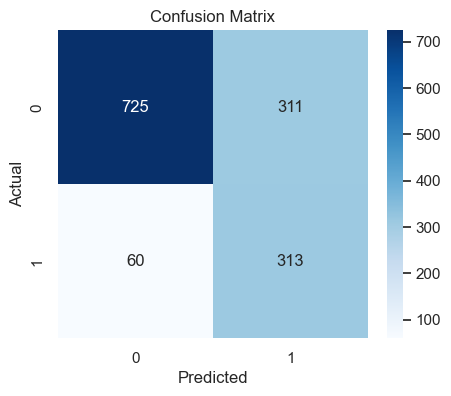

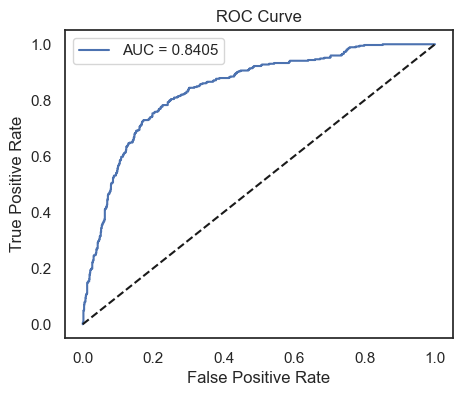

{'accuracy': 0.7366926898509581,
 'precision': 0.5016025641025641,
 'recall': 0.839142091152815,
 'specificity': np.float64(0.6998069498069498),
 'f1': 0.6278836509528586,
 'auc': 0.8405045700622108,
 'r2': -0.3527461778132017,
 'confusion_matrix': array([[725, 311],
        [ 60, 313]])}

In [33]:
evaluate_sklearn_model(model, X_test, y_test)

### SVM

In [35]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn-Prediction-Model-Intro-to-ML-and-DL-Project-\Utils\dataset_preparation.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
d:\KMITL\year_4\Intro_to_DL_and_ML\Project\Telco-Churn

##### SVM lib

In [ ]:
model = svm.SVC().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8166489172878949, test set 0.8097941802696949


##### SVM from scratch

In [37]:
class SVM_Linear_Scratch:
    def __init__(self, C=1, batch_size=100, learning_rate=0.001, iterations=1000):
        self.C = C
        self.batch_size = batch_size
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.w = None
        self.b = None

    def decision_function(self, X):
        return np.dot(X, self.w) + self.b

    def hingeloss(self, w, b, x, y):
        reg = 0.5 * np.dot(w, w)
        loss = 0
        for i in range(x.shape[0]):
            opt_term = y[i] * (np.dot(w, x[i]) + b)
            loss += max(0, 1 - opt_term)
        return reg + self.C * loss

    def fit(self, X, Y):
        # ensure numpy
        X = np.array(X)
        Y = np.array(Y)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        losses = []

        # convert labels to -1, 1
        Y = np.where(Y <= 0, -1, 1)

        for i in range(self.iterations):
            l = self.hingeloss(self.w, self.b, X, Y)
            losses.append(l)

            for batch_start in range(0, n_samples, self.batch_size):
                gradw = np.zeros(n_features)
                gradb = 0
                for idx in range(batch_start, min(batch_start + self.batch_size, n_samples)):
                    if Y[idx] * self.decision_function(X[idx]) >= 1:
                        continue
                    else:
                        gradw += self.C * Y[idx] * X[idx]
                        gradb += self.C * Y[idx]

                # update
                self.w += self.learning_rate * gradw
                self.b += self.learning_rate * gradb

        return self

    def predict(self, X):
        X = np.array(X)  # ensure numpy
        prediction = self.decision_function(X)
        label_signs = np.sign(prediction)
        return np.where(label_signs <= -1, 0, 1)


In [38]:
svm_ls1 = SVM_Linear_Scratch(C=1)
svm_ls1.fit(X_train, y_train)
pred_ls1 = svm_ls1.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_ls1))


Accuracy: 0.8190205819730305



Evaluation Results:
Accuracy: 0.8190
Precision: 0.6941
Sensitivity (Recall): 0.5657
Specificity (TNR): 0.9102
F1-score: 0.6233
ROC AUC: 0.8527
R² score: 0.0702
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.57      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



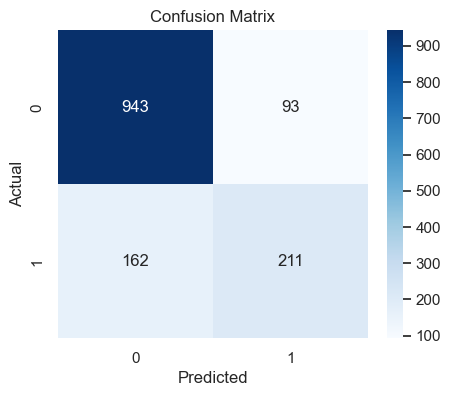

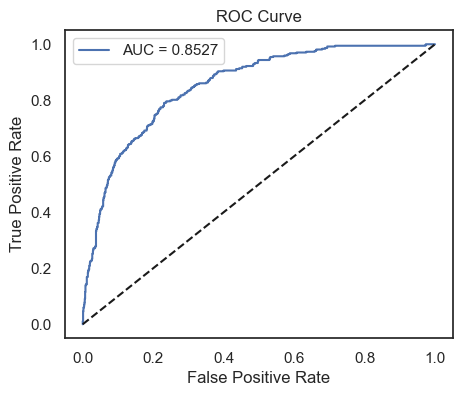

{'accuracy': 0.8190205819730305,
 'precision': 0.694078947368421,
 'recall': 0.5656836461126006,
 'specificity': np.float64(0.9102316602316602),
 'f1': 0.6233382570162481,
 'auc': 0.8527060668481581,
 'r2': 0.07021489126046787,
 'confusion_matrix': array([[943,  93],
        [162, 211]])}

In [40]:
evaluate_sklearn_model(svm_ls1, X_test, y_test)

## Tree Base

### Decision Tree

In [7]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = True
)

In [ ]:
y_train.value_counts()

label
0    4138
1    4138
Name: count, dtype: int64

In [ ]:
def decision_tree_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    max_depth = trial.suggest_int("max_depth", 1 ,40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)

    model = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [ ]:
model = tree.DecisionTreeClassifier().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.9990333494441759, test set 0.71611071682044


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: decision_tree_model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=200)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-27 00:07:32,136] A new study created in memory with name: no-name-5e06ccb4-5a0d-4edf-adf7-d0fe0ee4cb45
[I 2025-09-27 00:07:32,209] Trial 0 finished with value: 0.7267565649396736 and parameters: {'max_depth': 27, 'min_samples_split': 6}. Best is trial 0 with value: 0.7267565649396736.
[I 2025-09-27 00:07:32,278] Trial 1 finished with value: 0.7317246273953159 and parameters: {'max_depth': 35, 'min_samples_split': 7}. Best is trial 1 with value: 0.7317246273953159.
[I 2025-09-27 00:07:32,333] Trial 2 finished with value: 0.7750177430801988 and parameters: {'max_depth': 9, 'min_samples_split': 12}. Best is trial 2 with value: 0.7750177430801988.
[I 2025-09-27 00:07:32,400] Trial 3 finished with value: 0.7395315826827538 and parameters: {'max_depth': 29, 'min_samples_split': 15}. Best is trial 2 with value: 0.7750177430801988.
[I 2025-09-27 00:07:32,467] Trial 4 finished with value: 0.7317246273953159 and parameters: {'max_depth': 29, 'min_samples_split': 9}. Best is trial 2 wi

Best parameters: {'max_depth': 5, 'min_samples_split': 11}
Best accuracy: 0.7771469127040455


In [ ]:
model = tree.DecisionTreeClassifier(
            max_depth=5,
        min_samples_split=11).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8173030449492509, test set 0.7771469127040455


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



ROC AUC Score: 0.8084481455795128


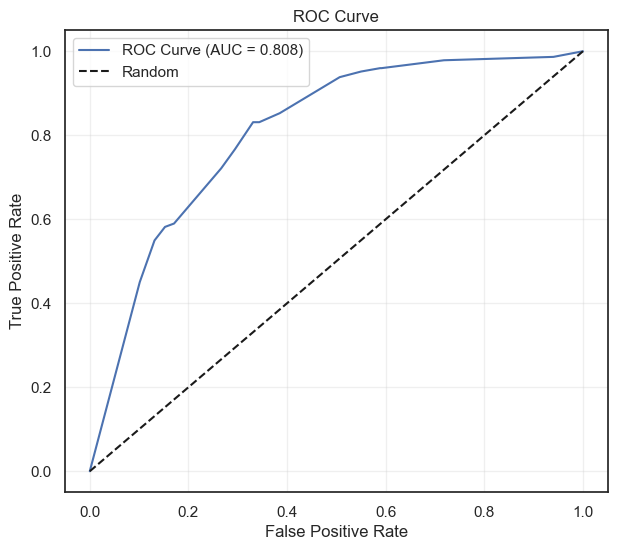

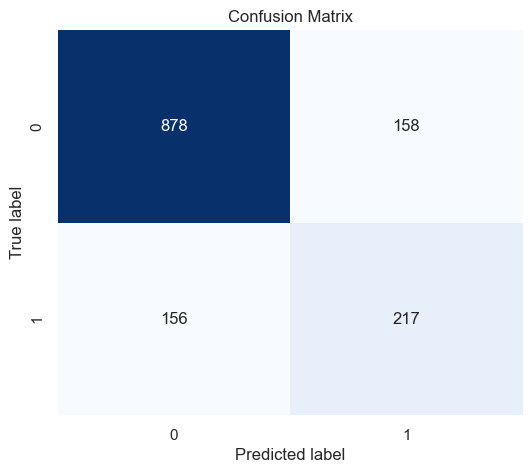

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------
# Confusion Matrix
# ------------------------
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

##### from scratch decision tree

In [10]:
import numpy as np

class DecisionNode:
    def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
        self.left = left
        self.right = right
        self.impurity = impurity
        self.feature_index = feature_index
        self.threshold = threshold

class LeafNode:
    def __init__(self, y):
        self.prediction_value = self._leaf_value_calculation(y)
        self.proba = self._leaf_distribution(y)

    def _leaf_value_calculation(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def _leaf_distribution(self, y):
        # Binary classification → probability distribution [P(class=0), P(class=1)]
        values, counts = np.unique(y, return_counts=True)
        total = len(y)
        dist = {0: 0.0, 1: 0.0}
        for val, count in zip(values, counts):
            dist[int(val)] = count / total
        return dist  # dictionary with probs

class DecisionTreeClassifierFromScratch:
    def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
        self.root = None
        self.min_sample_split = min_sample_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.impurity_function = self._calculate_information_gain
        self.criterion = self._gini_index if criterion == "gini" else self._entropy
        self.criterion_name = criterion

    def _gini_index(self, y):
        gini = 1
        for val in np.unique(y):
            p = np.sum(y == val) / len(y)
            gini -= p ** 2
        return gini

    def _entropy(self, y):
        entropy = 0
        for val in np.unique(y):
            p = np.sum(y == val) / len(y)
            entropy += -p * np.log2(p)
        return entropy

    def _calculate_information_gain(self, y, y1, y2):
        p = len(y1) / len(y)
        return self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)

    def _partition_dataset(self, Xy, feature_index, threshold):
        col = Xy[:, feature_index]
        return Xy[col >= threshold], Xy[col < threshold]

    def _find_best_split(self, Xy):
        best_question, best_datasplit = None, {}
        largest_impurity = 0
        n_features = Xy.shape[1] - 1

        for feature_index in range(n_features):
            thresholds = np.unique(Xy[:, feature_index])
            for threshold in thresholds:
                true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)
                if len(true_xy) > 0 and len(false_xy) > 0:
                    y, true_y, false_y = Xy[:, -1], true_xy[:, -1], false_xy[:, -1]
                    impurity = self.impurity_function(y, true_y, false_y)
                    if impurity > largest_impurity:
                        largest_impurity = impurity
                        best_question = (feature_index, threshold)
                        best_datasplit = {
                            "leftX": true_xy[:, :n_features],
                            "lefty": true_xy[:, n_features:],
                            "rightX": false_xy[:, :n_features],
                            "righty": false_xy[:, n_features:]
                        }
        return largest_impurity, best_question, best_datasplit

    def _build_tree(self, X, y, current_depth=0):
        n_samples, n_features = X.shape
        Xy = np.column_stack((X, y))

        if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
            impurity, question, best_datasplit = self._find_best_split(Xy)
            if impurity > self.min_impurity:
                true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
                false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
                return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                                    left=true_branch, right=false_branch)

        return LeafNode(y)

    def fit(self, X, y):
        self.root = self._build_tree(X, y, current_depth=0)

    def _predict_sample_node(self, x, tree):
        if isinstance(tree, LeafNode):
            return tree
        branch = tree.right
        if x[tree.feature_index] >= tree.threshold:
            branch = tree.left
        return self._predict_sample_node(x, branch)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_sample_node(sample, self.root).prediction_value for sample in X])

    def predict_proba(self, X):
        X = np.array(X)
        probs = []
        for sample in X:
            leaf = self._predict_sample_node(sample, self.root)
            probs.append([leaf.proba[0], leaf.proba[1]])  # [P(class=0), P(class=1)]
        return np.array(probs)


In [11]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, r2_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_Decision_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # For ROC AUC we need positive class probability
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred  

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity (TNR): {specificity:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"R² score: {r2:.4f}")
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.title("ROC Curve")
    plt.show()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "r2": r2,
        "confusion_matrix": cm
    }


In [12]:
tree = DecisionTreeClassifierFromScratch(max_depth=4)
tree.fit(X_train, y_train)


Evaluation Results:
Accuracy: 0.7324
Precision: 0.4966
Sensitivity (Recall): 0.7748
Specificity (TNR): 0.7172
F1-score: 0.6052
ROC AUC: 0.8022
R² score: -0.3746

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1036
           1       0.50      0.77      0.61       373

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.73      0.75      1409



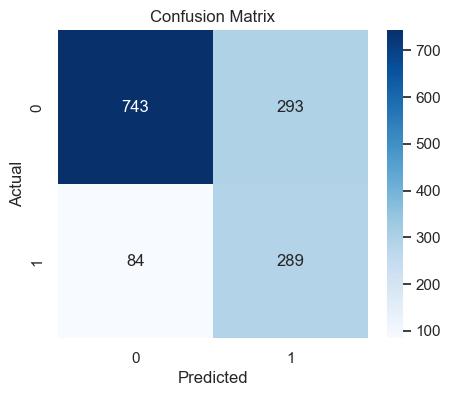

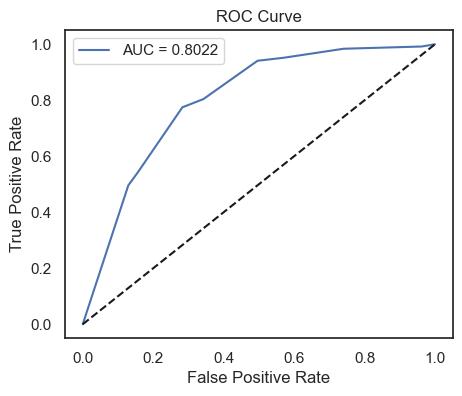

{'accuracy': 0.7324343506032647,
 'precision': 0.4965635738831615,
 'recall': 0.774798927613941,
 'specificity': np.float64(0.7171814671814671),
 'f1': 0.6052356020942409,
 'auc': 0.8021546057739087,
 'r2': -0.3746234744894259,
 'confusion_matrix': array([[743, 293],
        [ 84, 289]])}

In [14]:
evaluate_Decision_model(tree, X_test, y_test)

### Random Forest

In [15]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False
)

In [ ]:
def random_forest_model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    n_estimators = trial.suggest_int("max_depth", 50 ,300)
    max_depth = trial.suggest_int("max_depth", 1, 30)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth
    )

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


In [ ]:
model = RandomForestClassifier().fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.9985800496982605, test set 0.7913413768630234


##### Random forest from scratch

In [25]:
import numpy as np

class RandomForestClassifierFromScratch:
    def __init__(self, max_feature=None, n_trees=100, min_sample_split=2, 
                 min_impurity=1e-7, max_depth=10, criterion='gini'):
        self.trees = [
            DecisionTreeClassifierFromScratch(min_sample_split=min_sample_split,
                                              min_impurity=min_impurity,
                                              max_depth=max_depth,
                                              criterion=criterion)
            for _ in range(n_trees)
        ]
        self.tree_feature_indexes = []
        self.n_estimators = n_trees
        self.max_features = max_feature
        self.prediction_aggrigation_calculation = self._maximum_vote_calculation

    def _maximum_vote_calculation(self, y_preds):
        y_pred = np.empty((y_preds.shape[0], 1))
        for i, sample_predictions in enumerate(y_preds):
            y_pred[i] = np.bincount(sample_predictions.astype(int)).argmax()
        return y_pred

    def _make_random_subset(self, X, y, n_subsets, replacement=True):
        subset = []
        sample_size = (X.shape[0] if replacement else (X.shape[0] // 2))
        Xy = np.column_stack((X, y))
        np.random.shuffle(Xy)
        for i in range(n_subsets):
            index = np.random.choice(range(sample_size), size=np.shape(range(sample_size)), replace=replacement)
            X_s = Xy[index][:, :-1]
            y_s = Xy[index][:, -1]
            subset.append({"X": X_s, "y": y_s})
        return subset

    def fit(self, X, y):
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_features = int(round(np.sqrt(n_features)))

        subsets = self._make_random_subset(X, y, self.n_estimators)
        for i, subset in enumerate(subsets):
            X_subset, y_subset = subset["X"], subset["y"]
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            self.tree_feature_indexes.append(idx)
            X_subset = X_subset[:, idx]
            y_subset = np.expand_dims(y_subset, axis=1)
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, test_X):
        # ensure numpy array
        if isinstance(test_X, pd.DataFrame):
            test_X = test_X.values  

        y_preds = np.empty((test_X.shape[0], self.n_estimators))

        # predictions from each tree
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]
            X_selected_features = test_X[:, features_index]  # now safe
            y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))

        # aggregate (majority vote)
        y_pred = self.prediction_aggrigation_calculation(y_preds)
        return y_pred


    def predict_proba(self, test_X):
        """Return class probabilities by averaging probabilities across all trees"""
        if isinstance(test_X, pd.DataFrame):
            test_X = test_X.values  

        y_preds = np.empty((test_X.shape[0], self.n_estimators))
        probs = np.zeros((test_X.shape[0], 2))  # binary classification → 2 columns
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]
            X_selected_features = test_X[:, features_index]
            tree_probs = tree.predict_proba(X_selected_features)  # each tree already supports predict_proba
            probs += tree_probs
        probs /= self.n_estimators  # average over all trees
        return probs


In [30]:
def evaluate_Decision_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # For ROC AUC we need positive class probability
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred  

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity (TNR): {specificity:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"R² score: {r2:.4f}")
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.title("ROC Curve")
    plt.show()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "r2": r2,
        "confusion_matrix": cm
    }

In [26]:
rf = RandomForestClassifierFromScratch(n_trees=50, max_depth=5)
rf.fit(X_train, y_train)
rf.predict(X_test)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [27]:
rf.predict_proba(X_test)

array([[0.49093618, 0.50906382],
       [0.88483238, 0.11516762],
       [0.96073173, 0.03926827],
       ...,
       [0.92229387, 0.07770613],
       [0.87388814, 0.12611186],
       [0.60108309, 0.39891691]])


Evaluation Results:
Accuracy: 0.7842
Precision: 0.7717
Sensitivity (Recall): 0.2627
Specificity (TNR): 0.9720
F1-score: 0.3920
ROC AUC: 0.8570
R² score: -0.1084

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87      1036
           1       0.77      0.26      0.39       373

    accuracy                           0.78      1409
   macro avg       0.78      0.62      0.63      1409
weighted avg       0.78      0.78      0.74      1409



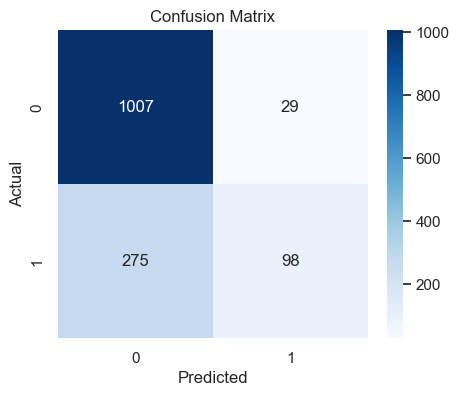

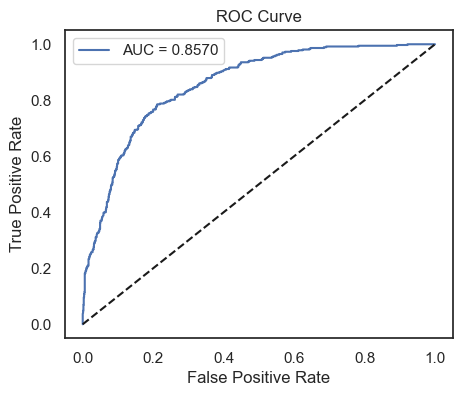

In [31]:
results = evaluate_Decision_model(rf, X_test, y_test)

### CatBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

class SimpleCatBoostLike:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.feature_encodings = {}
        self.base_pred = None  # initial prediction (log-odds)

    def _target_encode(self, X, y, categorical_features):
        X_enc = X.copy()
        y_series = pd.Series(y, name="__target__")  # always enforce a name
        X_enc = X_enc.assign(__target__=y_series)
        
        for col in categorical_features:
            means = X_enc.groupby(col)["__target__"].mean()
            self.feature_encodings[col] = means.to_dict()
            X_enc[col] = X_enc[col].map(self.feature_encodings[col])
        
        return X_enc.drop(columns=["__target__"])


    def transform_cats(self, X, categorical_features):
        """Apply learned encodings to new data"""
        X_enc = X.copy()
        for col in categorical_features:
            if col in self.feature_encodings:
                X_enc[col] = X_enc[col].map(self.feature_encodings[col]).fillna(0.5)
        return X_enc

    def fit(self, X, y, categorical_features=[]):
        # Encode categoricals
        X_enc = self._target_encode(X.assign(y=y), y, categorical_features)
        X_enc = X_enc.drop(columns=["y"], errors="ignore")

        # Initialize prediction with log-odds
        p = np.mean(y)
        self.base_pred = np.log(p / (1 - p))

        # Gradient boosting loop
        F = np.ones(len(y)) * self.base_pred
        for i in range(self.n_estimators):
            # Compute gradient (pseudo-residuals for logloss)
            p_hat = 1 / (1 + np.exp(-F))
            grad = y - p_hat

            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_enc, grad > 0)  # simplified fit (classification of sign of grad)

            update = tree.predict_proba(X_enc)[:,1]
            F += self.learning_rate * update

            self.models.append(tree)

            if (i+1) % 10 == 0:
                loss = log_loss(y, 1/(1+np.exp(-F)))
                print(f"Iter {i+1}/{self.n_estimators}, LogLoss: {loss:.4f}")

    def predict_proba(self, X, categorical_features=[]):
        X_enc = self.transform_cats(X, categorical_features)
        F = np.ones(len(X_enc)) * self.base_pred
        for tree in self.models:
            update = tree.predict_proba(X_enc)[:,1]
            F += self.learning_rate * update
        proba = 1 / (1 + np.exp(-F))
        return np.vstack([1-proba, proba]).T

    def predict(self, X, categorical_features=[]):
        proba = self.predict_proba(X, categorical_features)[:,1]
        return (proba > 0.5).astype(int)


In [ ]:
X_train, y_train, X_test, y_test = model_input_preparation(
    df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot_feature,
    normal_selected_feature,
    one_hot = False,
    scaler = False,
    test_size = 0.2,
    seed = 42,
    selected_feature = False,
    IS_SMOTE = False)

In [ ]:
scratch_model = SimpleCatBoostLike(n_estimators=30, learning_rate=0.1, max_depth=10)
scratch_model.fit(X_train, y_train, categorical_features=categorical_feature_list)
y_pred_scratch = scratch_model.predict(X_test, categorical_feature_list)
y_proba_scratch = scratch_model.predict_proba(X_test, categorical_feature_list)

Iter 10/30, LogLoss: 0.4883
Iter 20/30, LogLoss: 0.4404
Iter 30/30, LogLoss: 0.4316


In [ ]:
accuracy = accuracy_score(y_test, y_pred_scratch)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [ ]:
evaluate_model(scratch_model, test_loader, nn.CrossEntropyLoss())

NameError: name 'nn' is not defined

In [ ]:
y_train.value_counts()

label
0    4138
1    1496
Name: count, dtype: int64

In [ ]:
model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=100,      
    learning_rate=0.1,   
    depth=6,              
    verbose=0, 
    cat_features=categorical_feature_list
)

model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.76


In [ ]:
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409

